In [1]:
!pip uninstall -y mediapipe
!pip install mediapipe==0.10.20

Found existing installation: mediapipe 0.10.20
Uninstalling mediapipe-0.10.20:
  Successfully uninstalled mediapipe-0.10.20
  Using cached mediapipe-0.10.20-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
Using cached mediapipe-0.10.20-cp311-cp311-manylinux_2_28_x86_64.whl (35.6 MB)


In [11]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import mediapipe as mp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Configuration
data_path = "/content/drive/My Drive/Cmpt_419_Project/dataset_green/"
batch_size = 32
num_epochs = 100
learning_rate = 0.0002
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# MediaPipe Pose initialization
mp_pose = mp.solutions.pose

# 1. Extract Landmarks from Images
def extract_arm_landmarks(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose:
        results = pose.process(image_rgb)
        if not results.pose_landmarks:
            return None

        # Extract arm landmarks (left and right shoulders, elbows, wrists)
        landmark_indices = [11, 12, 13, 14, 15, 16]  # MediaPipe pose landmarks
        landmarks = []
        for idx in landmark_indices:
            lm = results.pose_landmarks.landmark[idx]
            landmarks.extend([lm.x, lm.y, lm.z])  # x, y, z coordinates

        return np.array(landmarks)


In [6]:
# Process dataset and save landmarks
def process_dataset(data_path):
    all_landmarks = []
    all_labels = []

    # Use the same label mapping as GestureImageDataset
    label_map = {"left": 0, "right": 1, "stop": 2}

    for class_name in label_map.keys():  # Only process defined classes
        class_dir = os.path.join(data_path, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                landmarks = extract_arm_landmarks(img_path)
                if landmarks is not None:
                    all_landmarks.append(landmarks)
                    all_labels.append(label_map[class_name])  # Use predefined label

    return np.array(all_landmarks), np.array(all_labels)

# Run processing
landmarks, labels = process_dataset(data_path)
print(f"Processed {len(landmarks)} samples")

Processed 88 samples


In [7]:
# 2. Create PyTorch Dataset
class ArmLandmarkDataset(Dataset):
    def __init__(self, landmarks, labels):
        self.landmarks = landmarks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (torch.tensor(self.landmarks[idx], dtype=torch.float32),
                torch.tensor(self.labels[idx], dtype=torch.long))

# Create dataset and split
dataset = ArmLandmarkDataset(landmarks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [12]:
# 3. Define Model Architecture
class ArmGestureNet(nn.Module):
    def __init__(self, input_size=18, num_classes=3):
        super(ArmGestureNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.4)
        self.batchnorm = nn.BatchNorm1d(128)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.batchnorm(x)
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
# Initialize model
model = ArmGestureNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# 4. Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item()

    # Print statistics
    train_acc = 100 * correct / total
    val_acc = 100 * val_correct / val_total
    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'Train Loss: {running_loss/len(train_loader):.4f}, Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss/len(val_loader):.4f}, Acc: {val_acc:.2f}%')

Epoch [1/100] Train Loss: 1.1022, Acc: 35.71% | Val Loss: 1.1023, Acc: 33.33%
Epoch [2/100] Train Loss: 1.0725, Acc: 45.71% | Val Loss: 1.1018, Acc: 33.33%
Epoch [3/100] Train Loss: 1.0468, Acc: 44.29% | Val Loss: 1.1007, Acc: 33.33%
Epoch [4/100] Train Loss: 1.0379, Acc: 52.86% | Val Loss: 1.0993, Acc: 33.33%
Epoch [5/100] Train Loss: 0.9630, Acc: 57.14% | Val Loss: 1.0972, Acc: 33.33%
Epoch [6/100] Train Loss: 0.9814, Acc: 70.00% | Val Loss: 1.0941, Acc: 38.89%
Epoch [7/100] Train Loss: 0.9037, Acc: 78.57% | Val Loss: 1.0903, Acc: 44.44%
Epoch [8/100] Train Loss: 0.8782, Acc: 85.71% | Val Loss: 1.0852, Acc: 61.11%
Epoch [9/100] Train Loss: 0.8315, Acc: 84.29% | Val Loss: 1.0781, Acc: 61.11%
Epoch [10/100] Train Loss: 0.8821, Acc: 95.71% | Val Loss: 1.0686, Acc: 61.11%
Epoch [11/100] Train Loss: 0.7865, Acc: 92.86% | Val Loss: 1.0565, Acc: 61.11%
Epoch [12/100] Train Loss: 0.7849, Acc: 90.00% | Val Loss: 1.0416, Acc: 61.11%
Epoch [13/100] Train Loss: 0.7733, Acc: 94.29% | Val Loss: 1.

In [15]:
# Save model
torch.save(model.state_dict(), '/content/drive/My Drive/Cmpt_419_Project/arm_gesture_landmark_model.pth')

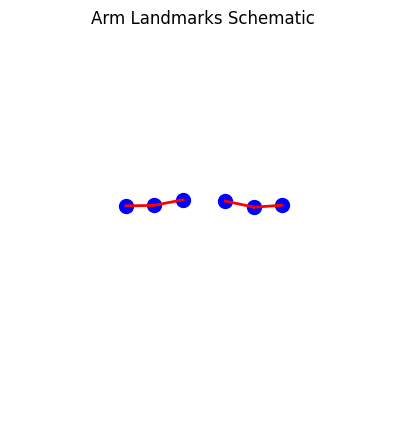

In [19]:
import matplotlib.pyplot as plt

def plot_landmarks(landmark_vector, img_size=200):
    """
    Visualize arm landmarks as a schematic image
    landmark_vector: 18-dim array (6 points × 3 coordinates)
    img_size: Output image size in pixels
    """
    # Reshape to 6 points with (x,y,z)
    points = landmark_vector.reshape(-1, 3)

    # Extract x,y coordinates (ignore z for 2D visualization)
    xs = points[:, 0]
    ys = 1 - points[:, 1]  # Flip Y-axis for more natural display

    # Create figure
    fig, ax = plt.subplots(figsize=(5, 5))

    # Plot connections (MediaPipe arm connections)
    connections = [
        (0, 2),  # Left shoulder to left elbow
        (2, 4),  # Left elbow to left wrist
        (1, 3),  # Right shoulder to right elbow
        (3, 5)   # Right elbow to right wrist
    ]

    # Draw connections
    for start, end in connections:
        ax.plot([xs[start], xs[end]], [ys[start], ys[end]],
                linewidth=2, color='red')

    # Plot landmarks
    ax.scatter(xs, ys, s=100, c='blue', marker='o')

    # Configure plot
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.title("Arm Landmarks Schematic")
    plt.show()

# Plot the first sample
if len(landmarks) > 0:
    plot_landmarks(landmarks[65])
else:
    print("No landmarks found - check your data processing")